In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'smartphone-image-denoising-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1469029%2F2427672%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240818%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240818T140007Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D66250592346116a5b1ba75528698f2457cb04a822ba4d0b5c8540339bb29902ce0dcf8ade5c1be5303256da961459dc08eb32f50b87e79006cec7be51442e0704713fe9116ce4cfc2d445fc9b2dda35c34d3ed423e9cf5a0dd8fba8baf94277575b7ca57a5bbee199c10311c1d9541fa7a024bf7c3b118f91a09df01d775475a81a3b12468f5ce44582d475c27560ffc431cc3e6b2d99e6104e42eb6206a52544611cb8492341f20cf375b9788bc7e0e5f0799547e2fe49109fe8450cb6c7bca88496dc3451c941daf1596e859fd7635de56ad42c2ea3a9fc154971a42f09c7ba9337f7f44e878ec105c5a19c57827c3289cad55b345effc2c0d3233dca4b401'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# imporitn necessary libraries
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [ ]:
# getting path of the dataset
data = "/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Data"
# after getting data lets iterate over the dataset
data_dir = os.listdir(data)
# now iterate over these approx 200 folders
new_data = []
for folder in data_dir:
    folder_path = os.path.join(data, folder)
#     ab is path pr iterate krwane ke liye use change to listdir
    folder_dir = os.listdir(folder_path)
    new_image = []
    for image in folder_dir:
#         first image is not noisy
#         2nd image is noisy
        image_dir = os.path.join(folder_path, image)
        new_image.append(image_dir)
    new_data.append(new_image)

In [ ]:
# # Now stack all the images from all folders
# new_data = np.stack(new_data)

new_data = np.array(new_data)
# new_data = torch.from_numpy(new_data)
x_noisy = new_data[:, 1]  #noisy images
y_clean = new_data[:, 0]  #clean images

In [ ]:
x_noisy.shape

(160,)

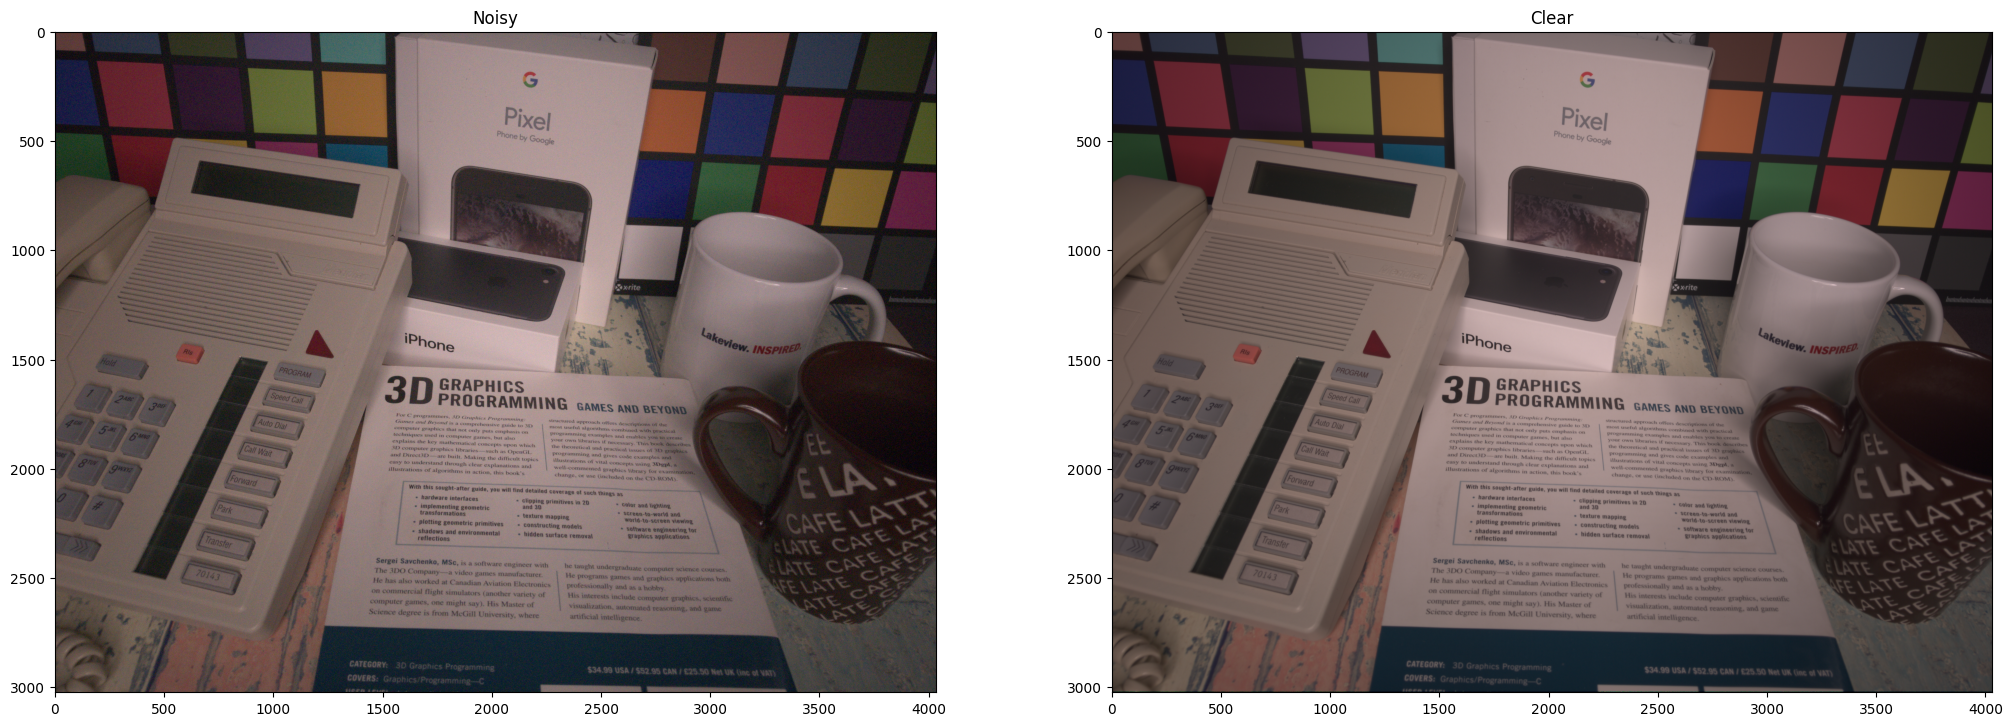

In [ ]:
x_img = Image.open(x_noisy[0])
x_img_array = np.asarray(x_img)

y_img = Image.open(y_clean[0])
y_img_array = np.asarray(y_img)
# plotting image to ensaure everything occur nicely till this
figure, axis = plt.subplots(1, 2, figsize = (25, 25))
axis[0].imshow(x_img_array)
axis[0].set_title("Noisy")
axis[1].imshow(y_img_array)
axis[1].set_title("Clear")
plt.show()

In [ ]:
# train test split
x_noisy_train, x_noisy_test, y_clean_train, y_clean_test = train_test_split(x_noisy, y_clean, shuffle = True, train_size = 0.7)
# set up data loader for training set
# loader = torch.utils.data.DataLoader(list(zip(x_noisy_train, y_clean_train)),batch_size = 32)
# cant do this dataset as zip as we need to apply transforms on train and test dataset

In [ ]:
x_noisy_train.shape, y_clean_train.shape, x_noisy_test.shape, y_clean_test.shape

((112,), (112,), (48,), (48,))

In [ ]:
# now I have to made a custom dataset
# lets do so by the class


class isha_Dataset(Dataset):
    def __init__(self, x, y, transform = None, transform_noise=None, transform_clean = None):
        self.x = x
        self.y = y
        self.transform = transform
        self.transform_noise = transform_noise
        self.transform_clean = transform_clean

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img_path_X, img_path_Y = self.x[idx], self.y[idx]
        img_noise, img_clean = Image.open(img_path_X), Image.open(img_path_Y)
        if self.transform:
            x_transformed = self.transform(img_noise)
            y_transformed = self.transform(img_clean)
        if self.transform_noise:
            x_transformed = self.transform_noise(x_transformed)
        if self.transform_clean:
            y_transformed = self.transform_clean(y_transformed)
        return (x_transformed, y_transformed)

In [ ]:
train_tranform_0 = transforms.Compose([
    transforms.CenterCrop(640),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])
test_transform_0 = transforms.Compose([
    transforms.CenterCrop(640),
    transforms.ToTensor(),
    # transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [ ]:
train_data = isha_Dataset(x_noisy_train, y_clean_train, transform = train_tranform_0)
test_data = isha_Dataset(x_noisy_test, y_clean_test, transform = test_transform_0)

In [ ]:
len(train_data), len(test_data)

(112, 48)

In [ ]:
# making dataloader
train_ltoader = torch.utils.data.DataLoader(dataset = train_data, batch_size = 8, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 8, shuffle = False)

In [ ]:
for img1, img2 in train_loader:
    print(img1.shape, img2.shape)
    break

torch.Size([8, 3, 640, 640]) torch.Size([8, 3, 640, 640])


In [ ]:
def YCrCb(images):
    Y = []
    for im in images:
#         print(im.shape)
        # color space change
        Y = 0.299*im[0] + 0.587*im[1] + 0.114*im[2]
        Cr = -0.14713*im[0] -0.28886*im[1] + 0.43600*im[2]
        Cb = 0.61500*im[0] -0.51499*im[1] -0.10001*im[2]
        im[0] = Y+0.5
        im[1] = Cr
        im[2] = Cb
    return images[:, 0:1, :, :]


In [ ]:
# preprocessing on transformed dataset
def PreprocessedData(dataloader):
    # now I have to change its color space
    # lets look to its dimension
    mean_noise = 0
    std_noise = 0
    mean_clean = 0
    std_clean = 0

    total_image_count = 0
    for  imgs_noise, imgs_clean in dataloader:
        image_count_in_batch = imgs_noise.size(0)

        ## for noisy image
        img_noise = imgs_noise.view(image_count_in_batch, imgs_noise.size(1), -1)
        mean_noise += img_noise.mean(2).sum(0)
        std_noise += img_noise.std(2).sum(0)

        ## for clean image
        img_clean = imgs_clean.view(image_count_in_batch, imgs_clean.size(1), -1)
        mean_clean += img_clean.mean(2).sum(0)
        std_clean += img_clean.std(2).sum(0)

        total_image_count += image_count_in_batch
        print("Done one Batch")
        # YCrCb(images)
    mean_noise /= total_image_count
    std_noise /= total_image_count
    mean_clean /= total_image_count
    std_clean /= total_image_count
    return (mean_noise, std_noise, mean_clean, std_clean)

In [ ]:
mean_noise, std_noise, mean_clean, std_clean = PreprocessedData(train_loader)

Done one Batch
Done one Batch
Done one Batch
Done one Batch
Done one Batch
Done one Batch
Done one Batch
Done one Batch
Done one Batch
Done one Batch
Done one Batch
Done one Batch
Done one Batch
Done one Batch


In [ ]:
mean_noise, std_noise, mean_clean, std_clean

(tensor([0.4092, 0.2848, 0.2579]),
 tensor([0.1809, 0.1519, 0.1414]),
 tensor([0.4167, 0.2895, 0.2650]),
 tensor([0.1679, 0.1435, 0.1248]))

In [ ]:
train_transform_1 = transforms.Compose([ transforms.CenterCrop(640),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

In [ ]:
train_data = isha_Dataset(x_noisy_train, y_clean_train, transform = train_transform_1,
                          transform_noise= transforms.Normalize(mean_noise, std_noise),
                         transform_clean = transforms.Normalize(mean_clean, std_clean))

In [ ]:
mean_noiseT, std_noiseT, mean_cleanT, std_cleanT = PreprocessedData(test_loader)

Done one Batch
Done one Batch
Done one Batch
Done one Batch
Done one Batch
Done one Batch


In [ ]:
test_transform_1 = transforms.Compose([
    transforms.CenterCrop(640),
    transforms.ToTensor(),
])

In [ ]:
test_data = isha_Dataset(x_noisy_test, y_clean_test, transform = test_transform_1,
                        transform_noise= transforms.Normalize(mean_noiseT, std_noiseT),
                         transform_clean = transforms.Normalize(mean_cleanT, std_cleanT))

In [ ]:
len(train_data), len(test_data)

(112, 48)

In [ ]:
# making dataloader
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = 8, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 8, shuffle = False)

In [ ]:
# def set_device():
#     if torch.cuda.is_available():
#         dev = 'cuda'
#     else:
#         dev = "cpu"

#     return torch.device(dev)

In [ ]:
class PiyushNet(nn.Module):
    def __init__(self):
        super(PiyushNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, (3, 3), 1, 1)
        self.conv2 = nn.Conv2d(63, 64, (3, 3), 1, 1)
        self.convS = nn.Conv2d(1, 1, (3, 3), 1, 1)

    def forward(self, img):
        #layer 1
        img1 = F.relu(self.conv1(img))
        imgS1 = self.convS(img)

        # layer 2
        img1_63 = img1[:, 0:63, :, :]
        img1_1 = img1[:, 63:64, :, :]
        img2 = F.relu(self.conv2(img1_63))
        imgS2 = self.convS(img1_1)


        # 3 layer
        img2_63 = img2[:, 0:63, :, :]
        img2_1 = img2[:, 63:64, :, :]
        img3 = F.relu(self.conv2(img2_63))
        imgS3 = self.convS(img2_1)

        # 4 layer
        img3_63 = img3[:, 0:63, :, :]
        img3_1 = img3[:, 63:64, :, :]
        img4 = F.relu(self.conv2(img3_63))
        imgS4 = self.convS(img3_1)

        # 5 layer
        img4_63 = img4[:, 0:63, :, :]
        img4_1 = img4[:, 63:64, :, :]
        img5 = F.relu(self.conv2(img4_63))
        imgS5 = self.convS(img4_1)

        # 6 layer
        img5_63 = img5[:, 0:63, :, :]
        img5_1 = img5[:, 63:64, :, :]
        img6 = F.relu(self.conv2(img5_63))
        imgS6 = self.convS(img5_1)

        # 7 layer
        img6_63 = img6[:, 0:63, :, :]
        img6_1 = img6[:, 63:64, :, :]
        img7 = F.relu(self.conv2(img6_63))
        imgS7 = self.convS(img6_1)

        # 8 layer
        img7_63 = img7[:, 0:63, :, :]
        img7_1 = img7[:, 63:64, :, :]
        img8 = F.relu(self.conv2(img7_63))
        imgS8 = self.convS(img7_1)

        # 9 layer
        img8_63 = img8[:, 0:63, :, :]
        img8_1 = img8[:, 63:64, :, :]
        img9 = F.relu(self.conv2(img8_63))
        imgS9 = self.convS(img8_1)

        # 10 layer
        img9_63 = img9[:, 0:63, :, :]
        img9_1 = img9[:, 63:64, :, :]
        img10 = F.relu(self.conv2(img9_63))
        imgS10 = self.convS(img9_1)

        # 11 layer
        img10_63 = img10[:, 0:63, :, :]
        img10_1 = img10[:, 63:64, :, :]
        img11 = F.relu(self.conv2(img10_63))
        imgS11 = self.convS(img10_1)

        # 12 layer
        img11_63 = img11[:, 0:63, :, :]
        img11_1 = img11[:, 63:64, :, :]
        img12 = F.relu(self.conv2(img11_63))
        imgS12 = self.convS(img11_1)

        # 13 layer
        img12_63 = img12[:, 0:63, :, :]
        img12_1 = img12[:, 63:64, :, :]
        img13 = F.relu(self.conv2(img12_63))
        imgS13 = self.convS(img12_1)

        # 14 layer
        img13_63 = img13[:, 0:63, :, :]
        img13_1 = img13[:, 63:64, :, :]
        img14 = F.relu(self.conv2(img13_63))
        imgS14 = self.convS(img13_1)

        # 15 layer
        img14_63 = img14[:, 0:63, :, :]
        img14_1 = img14[:, 63:64, :, :]
        img15 = F.relu(self.conv2(img14_63))
        imgS15 = self.convS(img14_1)

        # 16 layer
        img15_63 = img15[:, 0:63, :, :]
        img15_1 = img15[:, 63:64, :, :]
        img16 = F.relu(self.conv2(img15_63))
        imgS16 = self.convS(img15_1)

        # 17 layer
        img16_63 = img16[:, 0:63, :, :]
        img16_1 = img16[:, 63:64, :, :]
        img17 = F.relu(self.conv2(img16_63))
        imgS17 = self.convS(img16_1)

        # 18 layer
        img17_63 = img17[:, 0:63, :, :]
        img17_1 = img17[:, 63:64, :, :]
        img18 = F.relu(self.conv2(img17_63))
        imgS18 = self.convS(img1_1)

        # 19 layer
        img18_63 = img18[:, 0:63, :, :]
        img18_1 = img18[:, 63:64, :, :]
        img19 = self.conv2(img18_63)
        imgS19 = self.convS(img18_1)

        # 20 layer
        img19_63 = img19[:, 0:63, :, :]
        img19_1 = img19[:, 63:64, :, :]
        img20 = self.conv2(img19_63)
        imgS20 = self.convS(img19_1)

        ######
#         img20_1 = img20[:, 63:64, :, :]

#         result_img = img1_1 + img2_1 + img3_1 + img4_1 + img5_1 + img6_1 + img7_1 + img8_1 + img9_1 + img10_1
#         result_img = result_img + img11_1 + img12_1 + img13_1 + img14_1 + img15_1 + img16_1 + img17_1 + img18_1 + img19_1 + img20_1
        result_img = imgS1 + imgS2 + imgS3 + imgS4 + imgS5 + imgS6 + imgS7 + imgS8 + imgS9 + imgS10
        result_img = result_img + imgS11 + imgS12 + imgS13 + imgS14 + imgS15 + imgS16 + imgS17 + imgS18 + imgS19 + imgS20

        return result_img  + img

In [ ]:
class CNNnet(nn.Module):
    def __init__(self):
        super(CNNnet, self).__init__()
        self.conv1 = nn.Conv2d(1, 63, (3,3),1,1)
        self.conv2 = nn.Conv2d(1, 1, (3,3),1,1)
        self.conv3 = nn.Conv2d(63, 63, (3,3),1,1)
        self.conv4 = nn.Conv2d(63, 1, (3,3),1,1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x11 = self.conv2(x)

        x2 = F.relu(self.conv3(x1))
        x22 = self.conv4(x1)
        x22 = x22 + x11

        x3 = F.relu(self.conv3(x2))
        x33 = self.conv4(x2)
        x33 = x33 + x22

        x4 = F.relu(self.conv3(x3))
        x44 = self.conv4(x3)
        x44 = x44 + x33

        x5 = F.relu(self.conv3(x4))
        x55 = self.conv4(x4)
        x55 = x55 + x44

        x6 = F.relu(self.conv3(x5))
        x66 = self.conv4(x5)
        x66 = x66 + x55

        x7 = F.relu(self.conv3(x6))
        x77 = self.conv4(x6)
        x77 = x77 + x66

        x8 = F.relu(self.conv3(x7))
        x88 = self.conv4(x7)
        x88 = x88 + x77

        x9 = F.relu(self.conv3(x8))
        x99 = self.conv4(x8)
        x99 = x99 + x88

        x0 = self.conv3(x9)
        x00 = self.conv4(x9)
        x00 = x00 + x99

        return x00+x

In [ ]:
# device = set_device()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = CNNnet().to(device)
# net = PiyushNet().to(device)

In [ ]:
net.parameters()

<generator object Module.parameters at 0x7d0df09e3530>

In [ ]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr= 0.0001)

In [ ]:
def eval_model(model, test_loader):
    model.eval()
    total = 0
#     device = set_device()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for imgs_noise, imgs_clean in test_loader:
            imgs_noise = imgs_noise.to(device)
            imgs_clean = imgs_clean.to(device)
            datas = YCrCb(imgs_noise)
            outputs = model(datas)

In [ ]:
def train_nn(net, train_loader, test_loader,criterion, optimizer, n_epochs ):
#     device = set_device()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for epoch in range (n_epochs):
        print('epoch no....', epoch)
        running_loss = 0.0
        running_correct = 0.0
        total = 0.0
        net.train()
        for imgs_noise, imgs_clean in train_loader:
            imgs_noise = imgs_noise.to(device)
            imgs_clean = imgs_clean.to(device)

#             print(imgs_noise.shape)
            imgs_noise = YCrCb(imgs_noise)
            imgs_clean = YCrCb(imgs_clean)
#             print(imgs_noise.shape)
            optimizer.zero_grad()
            outputs = net(imgs_noise)
            loss = criterion(outputs, imgs_clean)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_correct +=1
            print("one Batch done")
        epoch_loss = running_loss/len(train_loader)
        savecheckpoints(net, n_epochs, optimizer)
        print('epoch loss: %.3f ',epoch_loss)


        # evaluate model on test dataset
    eval_model(net, test_loader)
    print("finished")
    return net

In [ ]:
# now saving the model
def savecheckpoints(model, epoch, optimizer):
    state = {
        'model':model.state_dict(),
        'epoch':epoch+1,
        'optimizer':optimizer.state_dict(),
        'comments':'very cool model',
    }
    torch.save(state, 'mdoel_best_checkponts.pth.tar')

In [ ]:
train_nn(net, train_loader, test_loader, loss_function, optimizer,n_epochs=5)

epoch no.... 0
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
epoch loss: %.3f  1.150350992168699
epoch no.... 1
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
epoch loss: %.3f  1.3481961020401545
epoch no.... 2
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
epoch loss: %.3f  1.293448167187827
epoch no.... 3
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Batch done
one Ba

CNNnet(
  (conv1): Conv2d(1, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(63, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(63, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
checkpoint = torch.load('mdoel_best_checkponts.pth.tar')

In [ ]:
print(checkpoint['epoch'])
print(checkpoint['comments'])

6
very cool model


In [ ]:
torch.save(net, 'best_model.pth')

In [ ]:
model = torch.load('best_model.pth')

In [ ]:
def YCrCbim(im):
    Y = []
    # for im in images:
    # print(im.shape)
    # color space change
    Y = 0.29900*im[0] + 0.58700*im[1] + 0.11400*im[2]
    Cr = -0.14713*im[0] -0.28886*im[1] + 0.43600*im[2]
    Cb = 0.61500*im[0] -0.51499*im[1] -0.10001*im[2]
    im[0] = Y+0.5
    im[1] = Cr
    im[2] = Cb
    return im[:, :, :]

In [ ]:
def rgb( y, im):
    im[0] = y

    r= im[0] +1.13983*im[2]
    g = im[0] -0.39465*im[1] -0.58060*im[2]
    b =im[0] +2.03211*im[1]
    im[0] = r*125
    im[1] = g*125
    im[2] = b*125
    return im[:, :, :]


In [ ]:
def classify(model, image_tranform, image_path):
#     device = set_device()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.eval()
    image = Image.open(image_path)
    image = image_tranform(image).float()
    imageYCrCb = YCrCbim(image)
    # imgrgb = rgb(imageYCrCb)
    image = imageYCrCb[0:1, :, :]
    image = image.unsqueeze(0)
    image = image.to(device)
    output = model(image)
    out = output.squeeze(0)
    imgrgb = rgb(out, imageYCrCb)
    return imgrgb

In [ ]:
outpt = classify(model, test_transform_1, x_noisy[80])
outpt = outpt.int()

/tmp/ipykernel_34/2389496526.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3614.)
  plt.imshow(outpt.T)


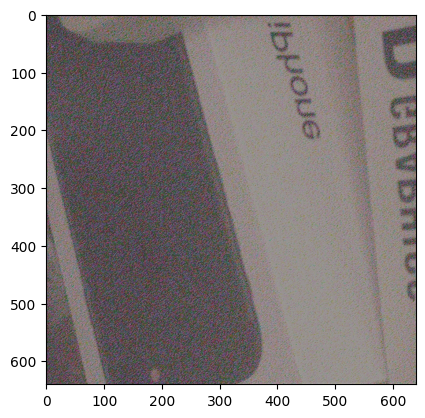

In [ ]:
plt.imshow(outpt.T)
plt.show()

In [ ]:
my_img_test = Image.open(x_noisy[80])
trf = transforms.Compose([
    transforms.CenterCrop(640),
    transforms.ToTensor(),
])

In [ ]:
my_img_test = trf(my_img_test)

In [ ]:
my_img_test.shape

torch.Size([3, 640, 640])

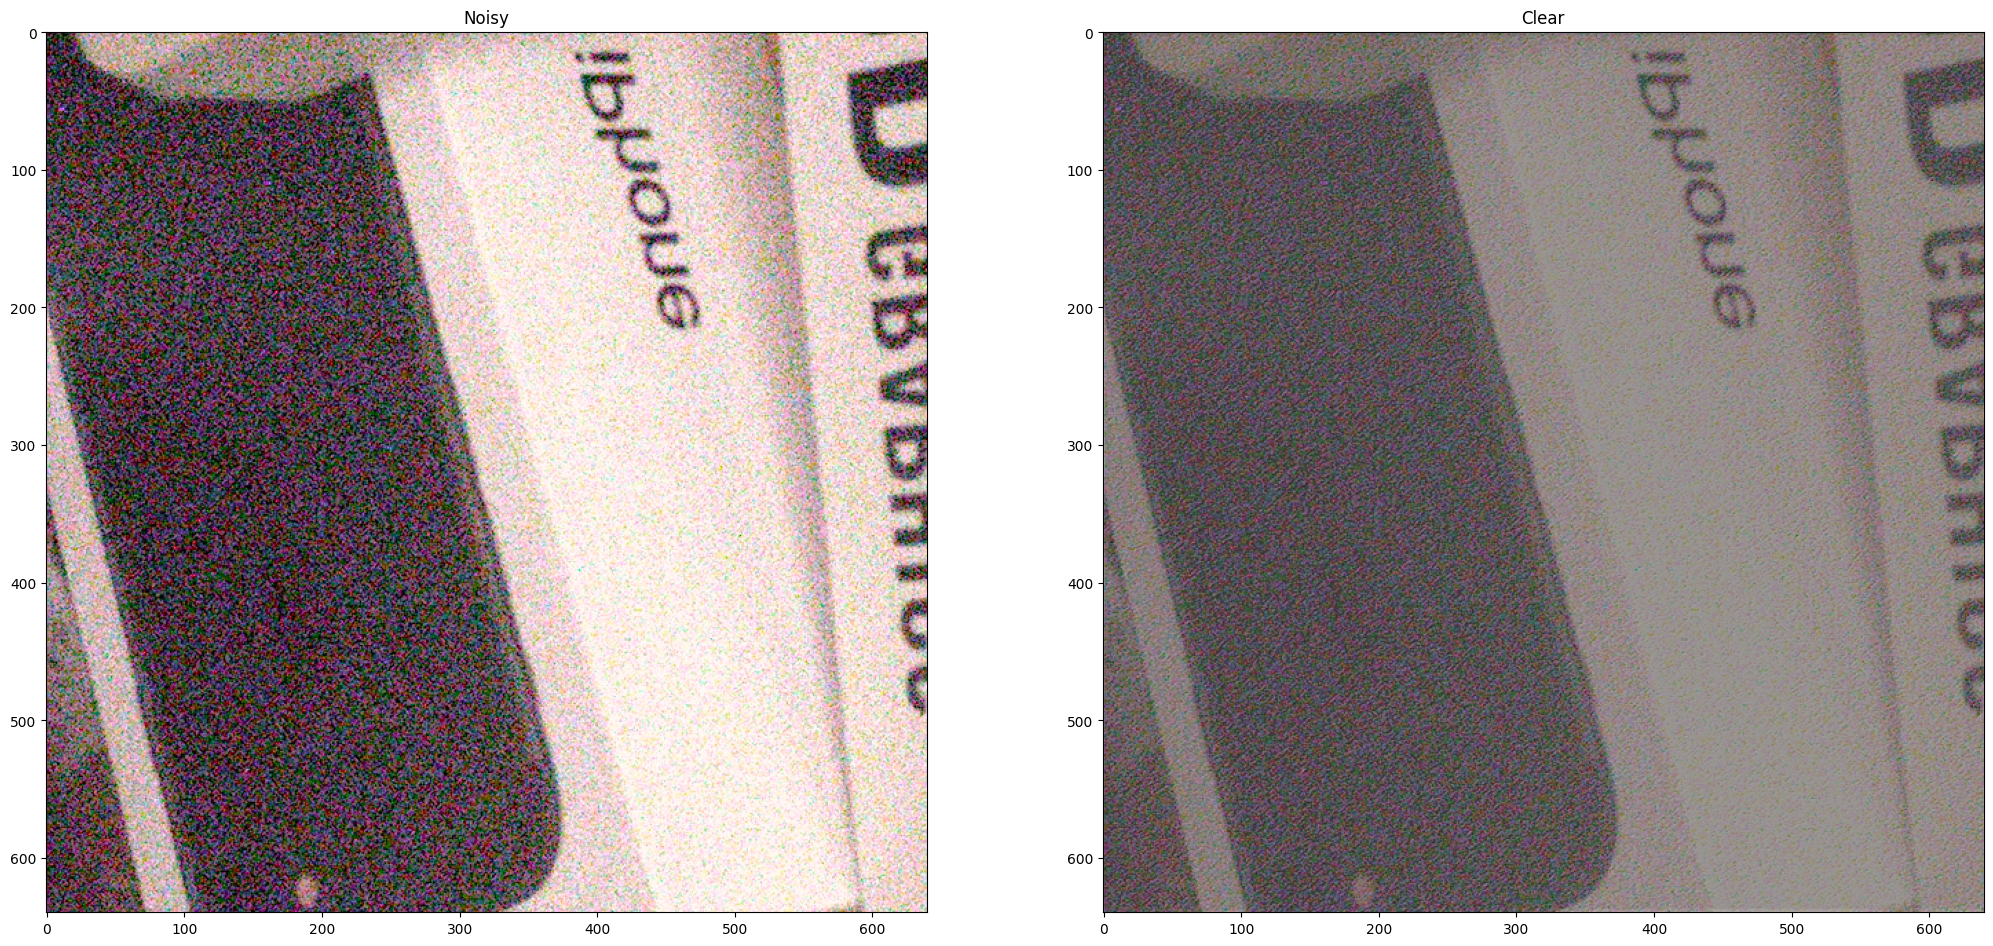

In [ ]:
# plotting image to ensaure everything occur nicely till this
figure, axis = plt.subplots(1, 2, figsize = (25, 25))
# my_img_test = Image.open(x_noisy[10])
axis[0].imshow(my_img_test.T)
axis[0].set_title("Noisy")
axis[1].imshow(outpt.T)
axis[1].set_title("Clear")
plt.show()